## Installation

Noise2void can be installed using mamba and pip. It is key to install a not-super-recent tensorflow as pointed out in the [n2v documentation](https://github.com/juglab/n2v?tab=readme-ov-file#installation).

```
mamba install n2v
```

```
pip install tensorflow==2.13
```

In [1]:
import n2v
from skimage.io import imread
import stackview

In [2]:
def train_noise2void(training_image,
                     validation_image,
                     number_training_epochs: int = 20,
                     train_batch_size: int = 4,
                     n2v_perc_pix=0.198,
                     model_directory: str = "my_n2v_model",
                     model_description: str = "none",
                     model_authors: str = "unknown"
                    ):
    """
    Train a noise2void denoiser from a single 2D image. After training and storing the model,
    it is also applied to the training image and the result is returned.
    
    

    See Also
    --------
    ..[0] https://github.com/juglab/n2v/blob/master/examples/2D/denoising2D_SEM/01_training.ipynb
    ..[1] https://github.com/juglab/n2v/blob/master/examples/3D/01_training.ipynb
    """
    from n2v.models import N2VConfig, N2V
    from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
    import numpy as np


    datagen = N2V_DataGenerator()
    patch_shape = (64, 64)
    axes = 'YXC'

    # Conform patch_shape for N2V_DataGenerator
    patch_shape = tuple(min(4 * ((s - 1) // 4), ps) for s, ps in zip(training_image.shape, patch_shape))

    data = np.asarray([training_image[..., np.newaxis]])
    data.shape
    print("data shape", data.shape)

    X = datagen.generate_patches(data, shape=patch_shape)
    X_val = datagen.generate_patches(np.asarray([validation_image[...,np.newaxis]]), shape=patch_shape)

    config = N2VConfig(X, unet_kern_size=3,
                       train_steps_per_epoch=int(X.shape[0] / 128),
                       train_epochs=number_training_epochs,
                       train_loss='mse',
                       batch_norm=True,
                       train_batch_size=train_batch_size,
                       n2v_perc_pix=n2v_perc_pix,
                       n2v_patch_shape=patch_shape,
                       n2v_manipulator='uniform_withCP',
                       n2v_neighborhood_radius=5)

    # the base directory in which our model will live
    basedir = 'models'
    # We are now creating our network model.
    model = N2V(config, model_directory, basedir=basedir)

    # We are ready to start training now.
    history = model.train(X, X_val)

    model.export_TF(name=model_directory,
                    description=model_description,
                    authors=model_authors.split(","),
                    test_img=X_val[0, ..., 0], axes=axes[:-1],
                    patch_shape=patch_shape)

    # apply the model and return the result
    return apply_noise2void(training_image, model_filename=model_directory)

@stackview.jupyter_displayable_output
def apply_noise2void(image,
                       model_directory: str = "my_n2v_model",
                       number_of_tiles: int = 4,
                      ):
    """
    Apply a noise2void model to a 2D image.

    Returns
    -------

    See Also
    --------
    ..[0] https://github.com/juglab/n2v/blob/master/examples/3D/02_prediction.ipynb
    ..[1] https://github.com/juglab/n2v/blob/master/examples/2D/denoising2D_SEM/02_prediction.ipynb
    """
    from n2v.models import N2V
    import numpy as np

    basedir = 'models'
    model = N2V(config=None, name=model_directory, basedir=basedir)
    
    axes = "YXC"
    tiles = (number_of_tiles, number_of_tiles, 1)

    predicted_image = model.predict(image[..., np.newaxis], axes=axes, n_tiles=tiles)
    return predicted_image[..., 0]

The images we use here were provided by the n2v maintainers from this url: https://download.fht.org/jug/n2v/SEM.zip

StackViewNDArray([[18819., 39590., 59738., ..., 29288., 26168., 21698.],
                  [58702., 10635., 29692., ..., 16055.,  3391.,  6221.],
                  [36831., 43770., 47552., ..., 35568., 28558., 26458.],
                  ...,
                  [65535., 53739., 39777., ..., 55260., 60074., 64232.],
                  [53884., 32396., 48983., ..., 65535., 62192., 65535.],
                  [59452., 60240., 40953., ..., 64029., 65535., 61550.]],
                 dtype=float32)
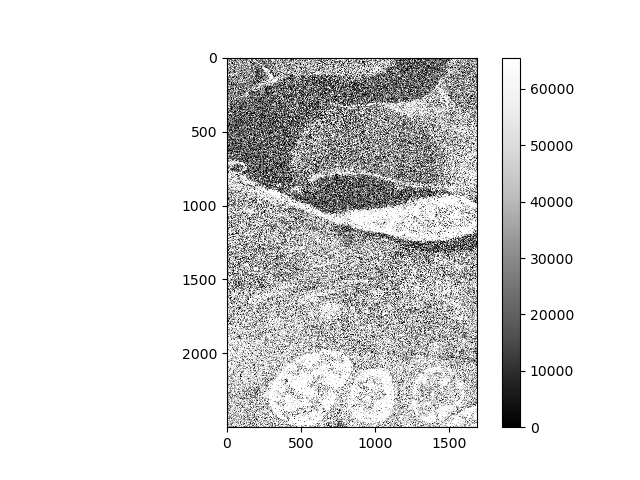
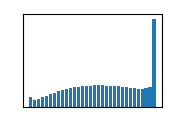

In [3]:
image_train = imread("data/train.tif")
stackview.insight(image_train)

StackViewNDArray([[53249., 40679., 65535., ..., 52082., 65535., 65535.],
                  [52783., 46859., 55873., ..., 65535., 64992., 55403.],
                  [26680., 52915., 62909., ..., 65535., 61537., 64971.],
                  ...,
                  [43259., 61475., 65316., ..., 11540., 53526., 50978.],
                  [46229., 28602., 55050., ..., 64502., 44813., 41843.],
                  [41424., 42439., 23842., ..., 43664., 29193.,  1984.]],
                 dtype=float32)
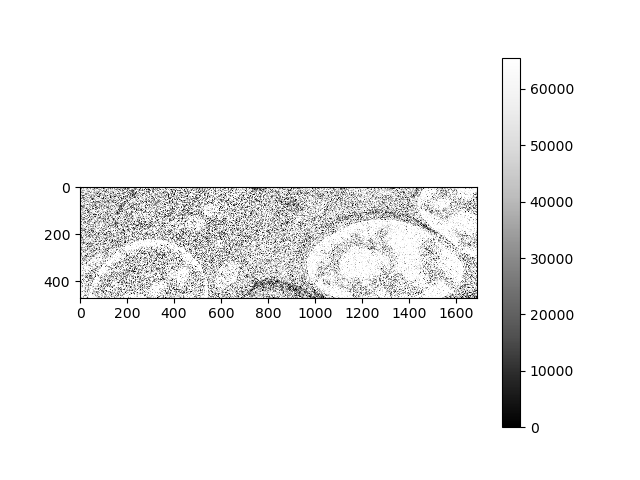
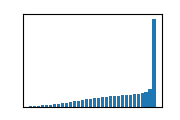

In [4]:
image_validation = imread("data/validation.tif")
stackview.insight(image_validation)

In [5]:
train_noise2void(image_train, image_validation)

data shape (1, 2500, 1690, 1)
Generated patches: (8112, 64, 64, 1)
Generated patches: (1456, 64, 64, 1)


C:\Users\haase\mambaforge\envs\tea3\lib\site-packages\n2v\models\n2v_standard.py:429: UserWarning: output path for model already exists, files may be overwritten: C:\structure\code\BIDS-lecture-2024\09a_dl_denoising\models\my_n2v_model
  warnings.warn(


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|█████████████████████████████████████████████████| 1456/1456 [00:00<00:00, 4634.18it/s]

Epoch 1/20


63/63 [==============================] - 14s 186ms/step - loss: 1.0903 - n2v_mse: 1.0903 - n2v_abs: 0.8390 - val_loss: 0.9386 - val_n2v_mse: 0.9378 - val_n2v_abs: 0.8520 - lr: 4.0000e-04
Epoch 2/20
63/63 [==============================] - 11s 174ms/step - loss: 0.8139 - n2v_mse: 0.8139 - n2v_abs: 0.7313 - val_loss: 0.8783 - val_n2v_mse: 0.8775 - val_n2v_abs: 0.8195 - lr: 4.0000e-04
Epoch 3/20
63/63 [==============================] - 11s 176ms/step - loss: 0.7719 - n2v_mse: 0.7719 - n2v_abs: 0.7199 - val_loss: 0.6741 - val_n2v_mse: 0.6734 - val_n2v_abs: 0.7025 - lr: 4.0000e-04
Epoch 4/20
63/63 [==============================] - 11s 176ms/step - loss: 0.7597 - n2v_mse: 0.7597 - n2v_abs: 0.7157 - val_loss: 0.5870 - val_n2v_mse: 0.5863 - val_n2v_abs: 0.6340 - lr: 4.0000e-04
Epoch 5/20
63/63 [==============================] - 11s 172ms/step - loss: 0.6820 - n2v_mse: 0.6820 - n2v_abs: 0.6825 - val_loss: 0.5797 - val_n2v_mse: 0.5788 - val_n2v_abs: 0.6092 - lr: 4.0000e-04
Epoch 6/20
63/63 [===

C:\Users\haase\mambaforge\envs\tea3\lib\site-packages\csbdeep\utils\tf.py:177: UserWarning: 
***IMPORTANT NOTE***

You are using 'tensorflow' 2.x, hence it is likely that the exported model *will not work*
in associated ImageJ/Fiji plugins (e.g. CSBDeep and StarDist).

If you indeed have problems loading the exported model in Fiji, the current workaround is
to load the trained model in a Python environment with installed 'tensorflow' 1.x and then
export it again. If you need help with this, please read:

https://gist.github.com/uschmidt83/4b747862fe307044c722d6d1009f6183

  config.gpu_options.per_process_gpu_memory_fraction = fraction



Model exported in BioImage ModelZoo format:
C:\structure\code\BIDS-lecture-2024\09a_dl_denoising\models\my_n2v_model\export.bioimage.io.zip


TypeError: apply_noise2void() got an unexpected keyword argument 'model_filename'

In [ ]:
denoised_train = apply_noise2void(image_train)
denoised_train

In [ ]:
stackview.curtain(image_train[::4,::4], denoised_train[::4,::4])

In [ ]:
stackview.curtain(image_train[1000:1500,1000:1500], denoised_train[1000:1500,1000:1500])